# SimCLR

https://arxiv.org/abs/2002.05709

Given gray level $M\times N$ images $X_i,\;i=1,\ldots,l$ and we define a image transformer $t$, including random crop, resize, rotation, brightness-adjust, etc. We want to train an encoder $f$ and a head $g$ such that minimize the cross entropy loss $L(g(f(t(X_i))), 1_i)$ where $1_i$ is an onehot vector having $i$th element $1$.

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future
import keras
from keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Activation
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50, preprocess_input

from keras.preprocessing import image as kpimage
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf

from glob import glob
import itertools
import pickle

In [2]:


# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 64

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'

# https://www.kaggle.com/moltean/fruits
train_path = '/tf/notebooks/data/simclr/train'
valid_path = '/tf/notebooks/data/simclr/valid'
test_path = '/tf/notebooks/data/simclr/test'
# train_path = '../large_files/fruits-360-small/Training'
# valid_path = '../large_files/fruits-360-small/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*')
valid_image_files = glob(valid_path + '/*/*')
test_image_files = glob(test_path + '/*/*')

# useful for getting number of classes
folders = glob(train_path + '/*')

In [3]:
def _load_image(p):
    return kpimage.img_to_array(kpimage.load_img(p, target_size=IMAGE_SIZE)).astype('uint8')

load_image = np.vectorize(_load_image, signature='()->(a,b,c)')

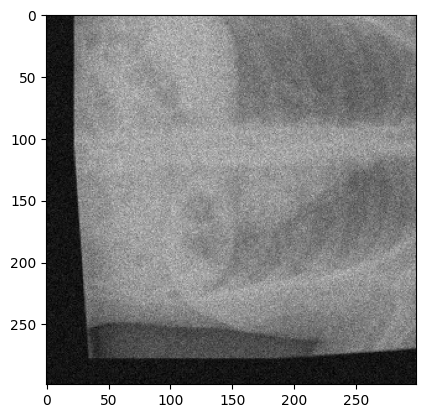

In [4]:

# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [5]:
def make_pair_data(root_dir):
    all_cls = glob(f'{root_dir}/*')
    assert len(all_cls) > 1

    while True:
        batch = []
        while len(batch) < batch_size:
            my_cls = np.random.choice(all_cls)
            im_my_cls = glob(f'{my_cls}/*')
            assert len(im_my_cls) > 1
            while (a:=np.random.choice(im_my_cls)) == (b:=np.random.choice(im_my_cls)):
                pass
            batch.append([a, b, 1])
            while (other_cls:= np.random.choice(all_cls)) == my_cls:
                pass
            im_ot_cls = glob(f'{other_cls}/*')
            assert len(im_ot_cls) >= 1
            while (a:=np.random.choice(im_my_cls)) == (b:=np.random.choice(im_ot_cls)):
                pass
            batch.append([a, b, 0])

        batch = np.array(batch[:batch_size])
        im = preprocess_input(load_image(batch[:,:2].T))
        lb = batch[:,-1].astype(float)
        yield [im[0], im[1]], lb

In [6]:
demo_ds = make_pair_data(train_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


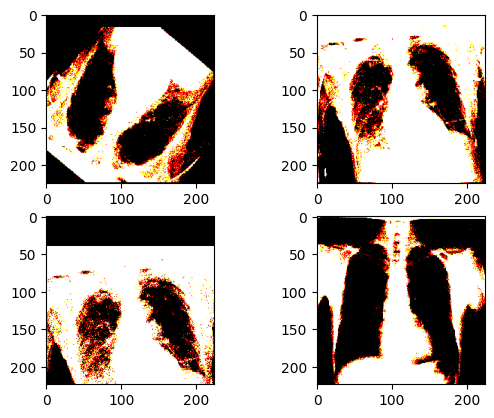

In [7]:
d = next(demo_ds)[0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.imshow(d[0][0])
ax2.imshow(d[1][0])
ax3.imshow(d[0][1])
ax4.imshow(d[1][1])
fig

# Building The Model

In [8]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


In [9]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [10]:
def accuracy(y_true, y_pred):
    """
    Computes the accuracy of the predictions.
    """

    # Notice that `y_true` is 0 whenever two images are not the same and 1
    # otherwise, but `y_pred` is the opposite. The closer `y_pred` is to 0,
    # the shorter the distance between both images, therefore the more likely
    # it is that they are the same image. To correctly compute the accuracy we
    # need to substract `y_pred` from 1 so both vectors are comparable.
    return tf.keras.metrics.binary_accuracy(y_true, 1 - y_pred)

In [11]:
# add preprocessing layer to the front of VGG
resnet = ResNet50(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

# our layers - you can add more if you want
feat_output = Flatten()(resnet.output)
feat_output = Dense(512)(feat_output)
feat_output = BatchNormalization()(feat_output)
features = Model(inputs=resnet.output, outputs=feat_output)

head_output = Activation('relu')(feat_output)
head_output = Dense(512)(head_output)
head_output = BatchNormalization()(head_output)
head_output = Activation('relu')(head_output)
head_output = Dense(256)(head_output)
head_output = BatchNormalization()(head_output)
head = Model(inputs=feat_output, outputs=head_output)

# feed both images into the same CNN
img_placeholder1 = Input(shape=IMAGE_SIZE+[3])
img_placeholder2 = Input(shape=IMAGE_SIZE+[3])

# get image features
feat1 = head(features(resnet(img_placeholder1)))
feat2 = head(features(resnet(img_placeholder2)))

dist_layer = Lambda(euclidean_distance)([feat1, feat2])
model = Model(inputs=[img_placeholder1, img_placeholder2], outputs=dist_layer)


In [12]:

# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

In [13]:
# tell the model what cost and optimization method to use
model.compile(
    loss=loss(margin=1),
    optimizer='adam',
    metrics=[accuracy]
)

In [14]:
# create generators
train_generator = make_pair_data(train_path)
valid_generator = make_pair_data(valid_path)

In [15]:
histories = []

In [ ]:
for i in range(1000):
    # fit the model
    print(i)
    r = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        steps_per_epoch=len(image_files) // batch_size,
        validation_steps=len(valid_image_files) // batch_size,
    )
    histories.append(r)
    model.save(f'/tf/notebooks/model/resnet-simclr-{i}.model')
    pickle.dump([_r.history for _r in histories], open(f'/tf/notebooks/model/resnet-simclr.history', 'wb'))

0
Epoch 1/5
224/438 [==============>...............] - ETA: 1:39 - loss: 204.4052 - accuracy: 0.5000

In [ ]:
# model = keras.models.load_model('/tf/notebooks/model/resnet-simclr-1.model', custom_objects={'contrastive_loss':
#                                                                                                  loss(margin=1)})

In [ ]:
# len(model.layers)

In [ ]:
# plot some data

# loss
plt.plot(r.history['loss'][1:], label='train loss')
plt.plot(r.history['val_loss'][1:], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'][1:], label='train acc')
plt.plot(r.history['val_accuracy'][1:], label='val acc')
plt.legend()
plt.show()